## **Imports**

In [3]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=a7135e590faf580aa246d35ec52aa65d3f16d9414b046b82c7fe5a43730e9e80
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [4]:
import librosa   #for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

## **Download Dataset**

In [5]:
!git clone https://github.com/getalp/ALFFA_PUBLIC.git

Cloning into 'ALFFA_PUBLIC'...
remote: Enumerating objects: 66024, done.
remote: Total 66024 (delta 0), reused 0 (delta 0), pack-reused 66024
Receiving objects: 100% (66024/66024), 6.54 GiB | 19.57 MiB/s, done.
Resolving deltas: 100% (12337/12337), done.
Checking out files: 100% (56925/56925), done.


## **Change Working Directory**

In [6]:
import os
os.chdir("ALFFA_PUBLIC/ASR/AMHARIC/")
len(os.listdir('data/train/wav/'))

10875

In [7]:
sample_rate = 44100//2

## **Load Audio Files**

In [15]:
def load_audio_files(path : str, sampling_rate : int, to_mono : bool) -> (dict, int):

  """
  Load the audio files and produce a dictionary mapping the audio filenames 
  to numpy arrays of the audio sampled at the given sample rate.

  Inputs: 
  path - a path to the directory that contains the audio files
  sample_rate - the sampling rate for the audio files
  to_mono - a boolean value denoting whether to convert signal to mono

  Returns:
  audio_files - audios - a dictionary mapping the wav file names to the sampled audio array
  max_length - the maximum length of a sampled audio array in our dataset
  """

  audio_files = {}
  max_length = 0
  i = 0
  for file in os.listdir(path):
    audio, rate= librosa.load(path+file, sr=sampling_rate, mono = to_mono)
    audio_files[file.split('.')[0]] = audio
    max_length = max(max_length,len(audio))
    i+=1
    if i%20 == 0:
      print('loaded',i,'audio files')
    if i == 100:
      break
  return audio_files, max_length

audio_files, maximum_length = load_audio_files('data/train/wav/', sample_rate, True)

loaded 20 audio files
loaded 40 audio files
loaded 60 audio files
loaded 80 audio files
loaded 100 audio files


In [16]:
print("The longest audio is",maximum_length/sample_rate, 'seconds long')

The longest audio is 15.488027210884354 seconds long


## **Load Transcripts**

In [17]:
def load_transcripts(filepath : str) -> dict:
  """
  Load the transcript file and produce a dictionary mapping the audio filenames 
  to the transcripts for those audio files.

  Inputs: 
  filepath - a path to the transcript file

  Returns:
  transcripts - a python dictionary mapping the wav file names to the transcripts
                of those audio files.
  """
  transcripts = {}
  with open (filepath, encoding="utf-8")as f:
    #print(f.readlines()[1])
    for line in f.readlines():
      
      text, filename = line.split("</s>")
      text, filename = text.strip()[3:], filename.strip()[1:-1]
      transcripts[filename] = text
    return transcripts

transcripts = load_transcripts("data/train/trsTrain.txt")

In [23]:
maximum_length

341511

**Sample audio along with transcript**

In [27]:
demo_audio = list(audio_files.keys())[1]

In [28]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

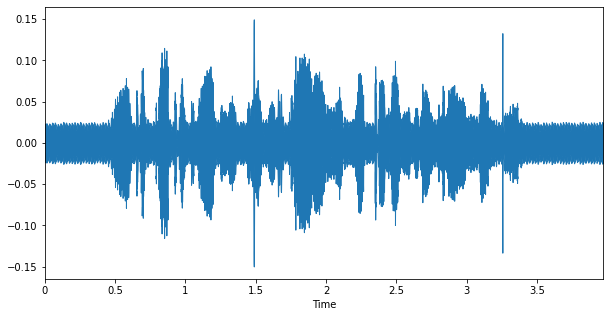

In [29]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(audio_files[demo_audio], sr=sample_rate)

In [30]:
transcripts[demo_audio]

' የ ኢትዮጵያ ተጨዋቾች ትንሽ ጫና እየ ፈጠሩ አስ ቸግረው ን ነበር'

 **Convert to Double Channel**

In [31]:
# def convert_to_double_channel(audios):
#   for name in audios:
#     if len(audios[name].shape) == 1:
#       audios[name] = np.array([audios[name],audios[name]])
#   return audios
# print(audio_files['tr_10027_tr097109'].shape)
# convert_to_double_channel(audio_files)
# print(audio_files['tr_10027_tr097109'].shape)

**Resize Audios For Double Channel**

In [32]:
# def resize_audios_double(audios,max_length):
#   for name in audios:
#     audios[name] = np.pad(audios[name], ((0,0),(0,max_length-audios[name].shape[1])), 'constant')
#   return audios

## **Resize Audios For Mono Channel**

In [34]:
def resize_audios_mono(audios : dict, max_length : int) -> dict:
  """
  Here we pad the sampled audio with zeros so tha all of the sampled audios 
  have equal length

  Inputs: 
  audios - a dictionary mapping the wav file names to the sampled audio array
  max_length - the maximum length of a sampled audio array in our dataset

  Returns:
  audios - a python dictionary mapping the wav file names to the padded
          audio samples
  """
  for name in audios:
    audios[name] = np.pad(audios[name], 
                          (0, max_length-len(audios[name])),
                          mode = 'constant')
  return audios

resize_audios_mono(audio_files, maximum_length)
print(audio_files[demo_audio].shape)

(341511,)


**Waveplot For Padded Audio**

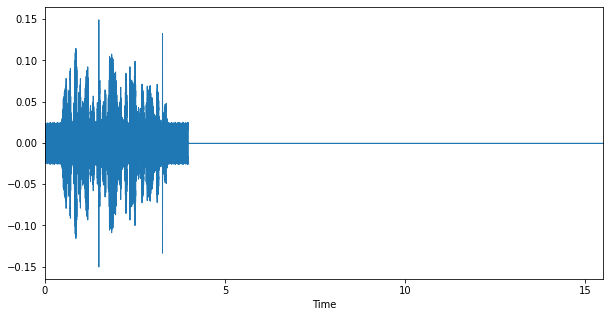

In [36]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(audio_files[demo_audio], sr= sample_rate)

**Sample Padded Audio**

In [38]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

## **Augment Audios**

In [39]:
def augment_audio(audios : dict, sample_rate : int) -> dict:
  """
  Here we shift the wave by sample_rate/10 factor. This will move the wave to the 
  right by given factor along time axis. For achieving this I have used numpy’s 
  roll function to generate time shifting.

  Inputs: 
  audios - a dictionary mapping the wav file names to the sampled audio array
  sample_rate - the sample rate for the audio

  Returns:
  audios - a python dictionary mapping the wav file names to the augmented 
          audio samples
  """
  for name in audios:
    audios[name] = np.roll(audios[name], int(sample_rate/10))
  return audios

augment_audio(audio_files, sample_rate)[demo_audio].shape

(341511,)

**Extract Features**

In [40]:
def extract_features(audios : dict, sample_rate : int) -> dict:
  """
  The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of 
  features (usually about 10–20) which concisely describe the overall shape of a 
  spectral envelope. It models the characteristics of the human voice.
  We compute the Mel frequency cepstral coefficients for each audio file.

  Inputs: 
  audios - a dictionary mapping the wav file names to the sampled audio array
  sample_rate - the sample rate for the audio

  Returns:
  mfcc_features - a python dictionary mapping the wav file names to the mfcc 
                  coefficients of the sampled audio files
  """
  mfcc_features = {}
  for audio in audios:
    mfcc_features[audio] = librosa.feature.mfcc(audios[audio], sr=sample_rate)
  return mfcc_features

mfcc_features = extract_features(audio_files, sample_rate)

**Plot MFCCs**

(20, 668)


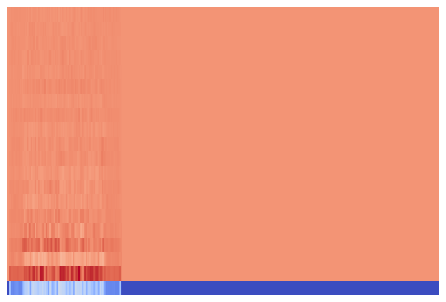

In [42]:
# MFCC
fig, ax = plt.subplots()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
mfccs = mfcc_features[demo_audio]
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

**Plot Mel Spectrogram**

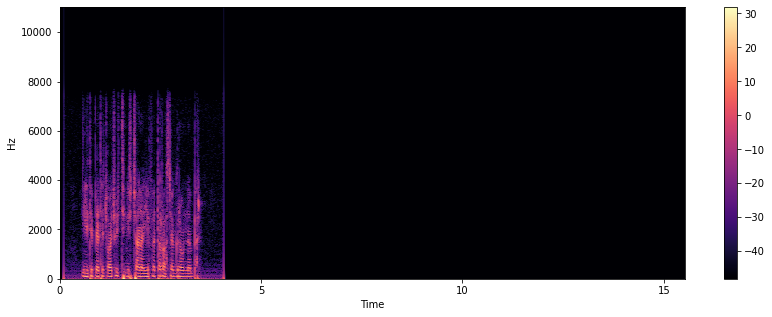

In [44]:
X = librosa.stft(audio_files[demo_audio])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

**Save MFCC Spectrogram Images**

In [45]:
!mkdir -p ../../../mfcc_train

def save_mfcc_spectrograms(mfccs: dict, sample_rate: int, path: str) -> int:
  """
  The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of 
  features (usually about 10–20) which concisely describe the overall shape of a 
  spectral envelope. It models the characteristics of the human voice.

  A Spectrogram captures the nature of the audio as an image by decomposing 
  it into the set of frequencies that are included in it.

  We plot the MFCC spectrogram for each audio file, and save the plots as .png 
  image files to the given target directory.

  Inputs: 
  mfccs - a python dictionary mapping the wav file names to the mfcc 
                  coefficients of the sampled audio files
  sample_rate - the sampling rate for the audio
  path - the file path to the target directory

  Returns:
  0 if the spectrograms were saved successfully, and 
  1 if there was a FileNotFoundError
  """
  for audio in mfccs:
      fig, ax = plt.subplots()
      ax = plt.Axes(fig, [0., 0., 1., 1.])
      ax.set_axis_off()
      fig.add_axes(ax)
      librosa.display.specshow(mfccs[audio], sr= sample_rate, x_axis='time')
      try:
          plt.savefig(path+f'{audio}.png', dpi = 100)
      except FileNotFoundError:
          print(f'The directory {path} does not exist')
          return 1
      fig.clear()
  return 0

save_mfcc_spectrograms(mfcc_features, sample_rate, '../../../mfcc_train/')


0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

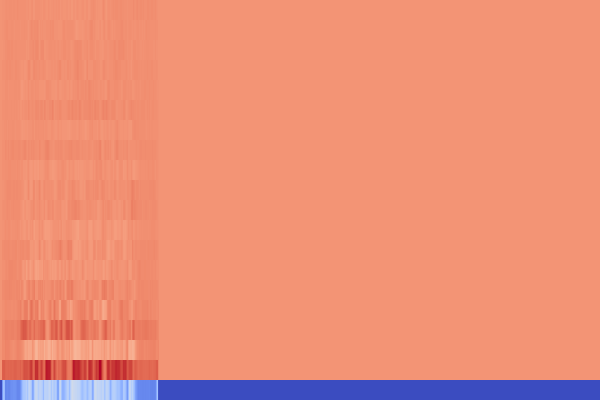

In [48]:
ipd.Image(filename=f'../../../mfcc_train/{demo_audio}.png')

In [ ]:
len(audio_files)

100